In [715]:
import pandas as pd
import glob
import numpy as numpy
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import seaborn as sns
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, BatchNormalization, TimeDistributed, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from multiprocessing import Process, Pool

import os
import multiprocessing as mp
import warnings
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
EARLIEST_DATE = '2012-01-01'

# REad in data

In [573]:

def read_in_data(check_recent_date=True, recent_date_check=datetime.datetime.now().date()):
    dict_of_stocks_and_dfs = {}
    for file_ in glob.glob('../data/updated_historical_stock_and_etf_data/*.csv'):
        stock_name = file_.rsplit("/")[-1].split('_')[0].lower() 
        print(f"Reading in {stock_name}")
        df_  = pd.read_csv(f"{file_}")
        # ensure we have the most recent data
        most_recent_date = pd.to_datetime(df_.date.max())
        oldest_date = pd.to_datetime(df_.date.min())
        
        oldest_date_bool = oldest_date < datetime.datetime(2006,1,1).date()
        recent_date_bool = most_recent_date == recent_date_check
        
        if oldest_date_bool and recent_date_bool:
            dict_of_stocks_and_dfs[stock_name] = df_.sort_values('date')
        elif oldest_date_bool and not check_recent_date:
            dict_of_stocks_and_dfs[stock_name] = df_.sort_values('date')            
        else:
            print(f"Stock {stock_name} most recent date is {most_recent_date} oldest date is {oldest_date}. Skipping it")
    return dict_of_stocks_and_dfs

In [574]:
dict_of_stocks_and_dfs = read_in_data(recent_date_check=datetime.datetime(2020,5,15).date())

Reading in wal
Reading in fsbw
Stock fsbw most recent date is 2020-05-15 00:00:00 oldest date is 2012-07-10 00:00:00. Skipping it
Reading in pfbc
Stock pfbc most recent date is 2020-05-15 00:00:00 oldest date is 2011-07-21 00:00:00. Skipping it
Reading in hasi
Stock hasi most recent date is 2020-05-15 00:00:00 oldest date is 2013-04-18 00:00:00. Skipping it
Reading in mtb
Reading in rbb
Stock rbb most recent date is 2020-05-15 00:00:00 oldest date is 2017-07-26 00:00:00. Skipping it
Reading in jpm
Reading in umpq
Reading in cvbf
Reading in fitb
Reading in irm
Reading in wfc
Reading in cwbc
Reading in bsrr
Reading in key
Reading in ewbc
Reading in dlr
Reading in ubfo
Reading in cvcy
Reading in hope
Stock hope most recent date is 2020-05-15 00:00:00 oldest date is 2011-12-05 00:00:00. Skipping it
Reading in pacw
Reading in ntrs
Reading in agnc
Stock agnc most recent date is 2020-05-15 00:00:00 oldest date is 2008-05-14 00:00:00. Skipping it
Reading in cma
Reading in nrz
Stock nrz most re

In [583]:
(len(dict_of_stocks_and_dfs.keys())-1) * len(dict_of_stocks_and_dfs.keys())

1482

# Create correlation features

In [599]:
def build_correlation_dfs(dict_of_stocks_and_dfs, n_day_rolling_features_list=[ 5, 7, 10, 30, 180, 365], verbose=False):
    """
    Create correlation + variance based  upon daily closing stock prices for given date ranges
    
    also include daily volume
    
    We are trying to  predict 7 day correaltion
    """

    stock_features_dict = defaultdict(pd.DataFrame)
    start_time = time.time()
    
    start = time.time()
    n_stocks = len(dict_of_stocks_and_dfs.keys())
    final_feature_df = create_date_dummy_df()
    pairs_of_stocks = []
    
    for idx, first_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
        print('')
        print(f"Finished {idx/n_stocks} pct of stocks")
        print('')
        for second_idx, second_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
            stock_pair = f"{first_stock_name}_{second_stock_name}"
            reverse_pair = f"{second_stock_name}_{first_stock_name}"
            
            if (first_stock_name == second_stock_name) or (stock_pair in pairs_of_stocks)  or (reverse_pair in pairs_of_stocks): # pnr -> ual same as ual -> pnr
                continue
            else:
                pairs_of_stocks.append(stock_pair)
            if verbose:
                print('-------')
                print(f"{first_stock_name} & {second_stock_name}")
                print('-------')
            
            # here the date is not the index, yet
            first_stock_df = dict_of_stocks_and_dfs[f"{first_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{first_stock_name}"].date.isin(dict_of_stocks_and_dfs[f"{second_stock_name}"].date), :]

            #  filter second df by the dates in first

            # here the date is not the index, yet
            second_stock_df = dict_of_stocks_and_dfs[f"{second_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{second_stock_name}"].date.isin(first_stock_df.date), :]
            
            # set the date as an index and sort by date
            first_stock_df = first_stock_df.sort_values('date')
            second_stock_df = second_stock_df.sort_values('date')

            first_stock_df = first_stock_df.set_index('date')
            second_stock_df = second_stock_df.set_index('date')
            
            all_features_df = pd.DataFrame()
            for rolling_idx, rolling_day in enumerate(n_day_rolling_features_list):
                if verbose:
                    print(f"Rolling calculations for {rolling_day}")
                features_df = create_correlation_and_variance_features(
                    first_stock_df, second_stock_df, rolling_day, final_feature_df, 
                    first_stock_name=first_stock_name, second_stock_name=second_stock_name)
                   
                current_feature_cols = set(features_df.columns)
                final_feature_cols = set(final_feature_df.columns)

                
                if (f"{first_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{first_stock_name}_volume"] = list(first_stock_df.volume)
                
                if (f"{second_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{second_stock_name}_volume"] = list(second_stock_df.volume)
                    
                if rolling_idx == 0: 
                    all_features_df = features_df
                else:
                    all_features_df = all_features_df.join(features_df, on='date', lsuffix='_left')
            

                    
            all_features_df.index = pd.to_datetime(all_features_df.index)
            final_feature_df = final_feature_df.join(all_features_df, on='date')

            if verbose:
                end = time.time()
                print(f"Building all features took {(end-start)/60} minutes")
                start = time.time()

    end_time = time.time()
    print(f"Total time {(end_time-start_time) / 60} minutes for {len(pairs_of_stocks)} pairs")
    final_feature_df = add_time_feature(final_feature_df)
    return final_feature_df, pairs_of_stocks
            
        

# Note: will eventuall need to add in 0s for stocks withour correlation data with other stocks due to date range

In [600]:
def create_date_dummy_df(start_date=datetime.datetime(1980,1,1), n_years=50):
    
    #  create dummy df with dates to join against
    list_of_dates  = []
    n_days = 365*n_years
    start_date = start_date

    for i in range(n_days):
        list_of_dates.append(start_date + datetime.timedelta(i))
    df_ = pd.DataFrame(list_of_dates, columns=['date'])
    
    df_.date_ =  pd.to_datetime(df_.date)
    return df_.set_index('date')
    

In [601]:
def add_time_feature(final_stock_df):
    
    days = [i.day for i in final_stock_df.index]
    months = [i.month for i in final_stock_df.index]
    quarters = [i.quarter for i in final_stock_df.index]
    years = [i.year for i in final_stock_df.index]
    
    us_holidays = holidays.UnitedStates()
    
    h_ = np.array([i in us_holidays for i in final_stock_df.index]).astype(int)


    final_stock_df['day'] = days
    final_stock_df['month'] = months
    final_stock_df['quarter'] = quarters
    final_stock_df['year'] = years
#     final_stock_df['is_holiday'] = h_
    
    return final_stock_df

In [602]:
def create_correlation_and_variance_features(first_stock_df, second_stock_df, n_days_stride, final_stock_df, 
                                             first_stock_name=None, second_stock_name=None, verbose=False):
    """
    n_days_stride: the  number of rolling days to calculate correlation for
    """
    n_rows = len(first_stock_df)

    previous_row = 0

    features_per_time_period = defaultdict(list)
    if verbose:
        print(f"Creating correlations + variance on close for {n_days_stride} days")
    
    rolling_close_df = pd.DataFrame(first_stock_df.close.rolling(
        n_days_stride).corr(second_stock_df.close)).rename(
        {'close': f"{first_stock_name}_{second_stock_name}_close_corr_rolling_{n_days_stride}_days"},axis=1).fillna(method='backfill').round(6)

    
    # add cols
    
    current_feature_cols = list(final_stock_df.columns)
    

    # as we go through different pairs will have multiple var / corr for the first stock
    # pnc_bar calcualtes corr for pnr
    #pnr_bat calculates corr for pnr
    # don't want the same cols
    if f"{first_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        
        rolling_close_std_first_stock =  first_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_first_stock
        
    if f"{second_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_close_std_second_stock =  second_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round( 6)
        rolling_close_df[f"{second_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_second_stock
        
    if f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_first_stock =  first_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_first_stock
        
    if f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_second_stock =  second_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_second_stock
    
    return rolling_close_df



In [603]:
# 2 minutes fo 210 pairs
final_stock_df, pairs_of_stocks = build_correlation_dfs(dict_of_stocks_and_dfs, verbose=False)


Finished 0.0 pct of stocks


Finished 0.02564102564102564 pct of stocks


Finished 0.05128205128205128 pct of stocks


Finished 0.07692307692307693 pct of stocks


Finished 0.10256410256410256 pct of stocks


Finished 0.1282051282051282 pct of stocks


Finished 0.15384615384615385 pct of stocks


Finished 0.1794871794871795 pct of stocks


Finished 0.20512820512820512 pct of stocks


Finished 0.23076923076923078 pct of stocks


Finished 0.2564102564102564 pct of stocks


Finished 0.28205128205128205 pct of stocks


Finished 0.3076923076923077 pct of stocks


Finished 0.3333333333333333 pct of stocks


Finished 0.358974358974359 pct of stocks


Finished 0.38461538461538464 pct of stocks


Finished 0.41025641025641024 pct of stocks


Finished 0.4358974358974359 pct of stocks


Finished 0.46153846153846156 pct of stocks


Finished 0.48717948717948717 pct of stocks


Finished 0.5128205128205128 pct of stocks


Finished 0.5384615384615384 pct of stocks


Finished 0.5641025641025641 pct of 

In [ ]:
# max number of stocks is ~300 NOT 990

In [604]:
len(final_stock_df.columns)

4957

In [585]:
len(final_stock_df.columns)

5777

# Prep code for NN

In [653]:
# prepare the data for LSTM model
def split_sequences(sequences, n_steps, y_col='pg_so_close_corr_rolling_7_days', start_idx=0, n_val=50, print_idx=100): #2200
    """
    sequences = input_data
    n_steps = n_days of data to give at a time
    
    only works for the currently set y_col
    """
    if y_col not in sequences.columns:
        raise ValueError('This y col does not exist in this df')
    
    X, y = list(), list()
    X_val, y_val = list(), list()
    
    n_sequences = len(sequences)
    print('n_sequences', n_sequences)

    for i in range(start_idx, n_sequences):
        if i == start_idx:
            print(f"Training idx start at {i}")
        if (i % print_idx == 0) and i != 0:
            print(f"Pct finished = {i/n_sequences}")
            
        # find the end of this pattern
        end_ix = i + n_steps 
        total_end_ix = end_ix + n_val
        # check if we are beyond the dataset
        if (total_end_ix) > n_sequences:
            print(f"Training idx end at {end_ix}")
            print('Total idx checked', total_end_ix)
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences.loc[:, sequences.columns != f"{y_col}"][i:end_ix]), np.array(
            sequences.loc[:, sequences.columns == f"{y_col}"].shift(-7).fillna(method='ffill').iloc[end_ix-1])

                                 
        X.append(seq_x)
        y.append(seq_y)
    
    val_start_idx = start_idx + n_sequences - (start_idx  + n_val -2)
    for i in range(val_start_idx, n_sequences):
        if i == val_start_idx:
            print(f"Val idx start at {val_start_idx}")
        if (i % print_idx == 0) and i != 0:
            print(f"Pct finished for val sequences = {i/n_sequences}")
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            print(f"Val idx end at {end_ix}")
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences.loc[:, sequences.columns != f"{y_col}"][i:end_ix]), np.array(
            sequences.loc[:, sequences.columns == f"{y_col}"].shift(-7).fillna(method='ffill').iloc[end_ix-1])
        
        
        X_val.append(seq_x)
        y_val.append(seq_y)
    
    

    X, y, X_val, y_val = array(X), array(y), array(X_val), array(y_val)
    
    # errors for standard scaler
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors  
    
    
    scalers = {}
    for i in range(X.shape[1]):
        scalers[i] = StandardScaler()
        X[:, i, :] = scalers[i].fit_transform(X[:, i, :]) 


    for i in range(X_val.shape[1]):
        X_val[:, i, :] = scalers[i].transform(X_val[:, i, :]) 
   # need  to do this again as standard scaler may have nans
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors 
    print('X val shape', X_val.shape)
    

    
    return X, y, X_val, y_val, scalers

    
    

In [ ]:
Conv2D()

In [759]:
def build_keras_model(n_steps, n_features, n_units=50, dropout_pct=0.02, n_layers = 1):
    model = Sequential()


    # define CNN model
#     model.add(TimeDistributed(Conv2D(n_units, kernel_and_pool_size))
#     model.add(TimeDistributed(MaxPooling2D(pool_size=kernel_and_pool_size))
#     model.add(TimeDistributed(Flatten()))

        
    model.add(LSTM(n_units, activation='relu', dropout=dropout_pct, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(BatchNormalization())
    for _ in range(n_layers):
        model.add(LSTM(n_units, activation='relu', dropout=dropout_pct, return_sequences=True))
        model.add(BatchNormalization())
    model.add(LSTM(n_units, activation='relu', dropout=dropout_pct))
    model.add(BatchNormalization())
    model.add(Dense(n_units))
    model.add(Dense(int(n_units/2)))
    model.add(Dense(1))
    #Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    #LR = 0.0001
    #clipnorm=1., clipvalue=0.5
    model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='mse', metrics=['mse'])
    return model

In [760]:
model = build_keras_model(30, 7610)

In [761]:
model.summary()

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_192 (LSTM)              (None, 30, 50)            1532200   
_________________________________________________________________
batch_normalization_183 (Bat (None, 30, 50)            200       
_________________________________________________________________
lstm_193 (LSTM)              (None, 30, 50)            20200     
_________________________________________________________________
batch_normalization_184 (Bat (None, 30, 50)            200       
_________________________________________________________________
lstm_194 (LSTM)              (None, 50)                20200     
_________________________________________________________________
batch_normalization_185 (Bat (None, 50)                200       
_________________________________________________________________
dense_189 (Dense)            (None, 50)              

In [666]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=300, verbose=1, restore_best_weights=True)

class PredictionCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.validation_data[0])
        print('prediction: {} at epoch: {}'.format(y_pred, epoch))


# Train a model

In [699]:
# train on all data
# predict for the upcoming week

def prediction_for_upcoming_week(final_stock_df,pairs_of_stocks,  job_id=None, verbose = True, print_idx=1, n_day_sequences=14, 
                                 start_date_training_data='2010-01-01', n_validation_sequences=30):
    final_stock_df = final_stock_df.dropna()
    final_stock_df = final_stock_df.sort_values(by='date')
    print(len(final_stock_df),  'len input final_stock_df')
    # add this to predictions
    stock_to_industry = pd.read_csv('../data/Industries stock list - all.csv')
    stock_to_industry.symbol = [i.lower() for i in stock_to_industry.symbol]

    final_stock_df = final_stock_df.dropna()
    most_recent_date = final_stock_df.index.max()

    prediction_end = most_recent_date + datetime.timedelta(7)



    test_df = final_stock_df.iloc[-n_day_sequences:, :]
    

    n_days_corr_predictions = 7


    pct_change_corr = []
    predicted_corr = []
    last_corr_for_prediction_day = []
    pred_dates = []
    first_stock_industries = []
    second_stock_industries = []
    
    first_model = True

    start = time.time()
    total_n = len(pairs_of_stocks)
    
    for idx,stock_pairing in enumerate(pairs_of_stocks):
        if idx % print_idx == 0 and verbose:
            print('----------')
            print(f"Stock pairing = {stock_pairing}")
            print(f"Pct finished = {idx/total_n}")
        first_stock_name, second_stock_name = stock_pairing.split('_')

        first_stock_industries.append(stock_to_industry[stock_to_industry.symbol == first_stock_name].industry.values[0])
        second_stock_industries.append(stock_to_industry[stock_to_industry.symbol == second_stock_name].industry.values[0])



        pred_col_name = f"{stock_pairing}_close_corr_rolling_{n_days_corr_predictions}_days"

        # remove the current 7-day corr for this stock
        # for 7 take rolling 7 days corr to the present day to predict off of
        
        ## TRAINING AND TESTING DATA
        X,y, X_val, y_val, scalers = split_sequences(final_stock_df[final_stock_df.index >= f"{start_date_training_data}"],
                                                     n_day_sequences, start_idx=0, 
                                    n_val=n_validation_sequences, y_col=f"{pred_col_name}") # 30 steps

        

        train_X, train_y = final_stock_df.loc[:, final_stock_df.columns != f"{pred_col_name}"],  final_stock_df[f"{pred_col_name}"].shift(-7).fillna(method='ffill') 
                                                           # get corr from 7 days in the future
        test_X, test_y = np.array(test_df.loc[:, test_df.columns != f"{pred_col_name}"]),  test_df[f"{pred_col_name}"]
        test_X = np.array(test_X).reshape(1, X.shape[1], X.shape[2])
        test_X = np.nan_to_num(test_X.astype(np.float32))
        
        for i in range(test_X.shape[1]):
            test_X[:, i, :] = scalers[i].transform(test_X[:, i, :]) 
        test_X = np.nan_to_num(test_X.astype(np.float32))
        
#         return X,y, X_val, y_val, test_X
        ## END TRAINING AND TESTING DATA 
        
        
        if first_model:
            smaller_model = build_keras_model(X.shape[1],X.shape[2])
            
        # test again at 700 epochs
        if first_model:
            start = time.time()
            # 800 epochs
            history = smaller_model.fit(x=X, y=y, batch_size=256, epochs=800, verbose=0, 
                      validation_data=(X_val, y_val), shuffle=False,  use_multiprocessing=False, callbacks=[early_stopping])
            end=time.time()

            print((end-start)/60,' minutes')
        else:

            # Freeze the layers except the last 5 layers
            for layer in smaller_model.layers[:-3]:
                layer.trainable = False
            # Check the trainable status of the individual layers

            for layer in smaller_model.layers:
                print(layer, layer.trainable)

            smaller_model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='mse', metrics=['mse'])
            
            start = time.time()
            history = smaller_model.fit(x=X, y=y, batch_size=256, epochs=200, verbose=0, 
                      validation_data=(X_val, y_val), shuffle=False,  use_multiprocessing=False, callbacks=[early_stopping])
            end=time.time()
            print((end-start)/60,' minutes')

    
        history_df  = pd.DataFrame(history.history)
        history_df[['mse', 'val_mse']].iloc[-100:, :].plot()
        plt.show()
        prediction = smaller_model.predict(test_X)[0][0] 

        if verbose and idx % print_idx==0:
            print(f"Prediction = {prediction}")



        last_corr_date = train_y.index.max()
        last_corr = train_y[train_y.index.max()]  
        if verbose and idx % print_idx==0:
            print(f"Last corr = {last_corr}")

        pred_dates.append(most_recent_date)
        predicted_corr.append(prediction)
        last_corr_for_prediction_day.append(last_corr)
        
        if verbose and idx % print_idx==0:
            print(f"{stock_pairing} corr7-day corr of close from {most_recent_date} to {prediction_end} is {prediction} ")
        
        first_model = False


    end = time.time()

    print(f"Predictions took {(end-start)/60} mins")

    squarred_difference = (np.array(last_corr_for_prediction_day)-np.array(predicted_corr))**2

    prediction_df = pd.DataFrame({ 'pred_date_start':pred_dates,'stock_pair':pairs_of_stocks,   'first_stock_industry': first_stock_industries, 
                   'second_stock_industry': second_stock_industries,
                   'predicted_corr': predicted_corr, 'last_7_day_corr_for_pred_date_start': last_corr_for_prediction_day, 
            'squarred_diff_7_day_cor': (np.array(last_corr_for_prediction_day)-np.array(predicted_corr))**2
                 })
    
    if job_id:
        tmp_filepath = '../data/tmp_prediction_dfs'
        if not os.path.isdir(f"{tmp_filepath}"):
            os.mkdir(f"{tmp_filepath}")
        prediction_df.to_csv(
        f'{tmp_filepath}/{job_id}_test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)
    else:
        prediction_df.to_csv(
    f'../data/predictions/lstm_test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)


In [700]:
len(pairs_of_stocks)

741

In [701]:
# should take ~4 hours for 378 pairs of stocks
# 6.5 minutes for 10 stocks

In [702]:
len(final_stock_df.columns)

4957

In [703]:
pairs_of_stocks[:2]

['wal_mtb', 'wal_jpm']

In [704]:
np.isnan(final_stock_df).sum().sum()

0

In [705]:
final_stock_df.columns

Index(['wal_mtb_close_corr_rolling_5_days', 'wal_close_std_rolling_5_days',
       'mtb_close_std_rolling_5_days', 'wal_volume_std_rolling_5_days',
       'mtb_volume_std_rolling_5_days', 'wal_volume', 'mtb_volume',
       'wal_mtb_close_corr_rolling_7_days', 'wal_close_std_rolling_7_days',
       'mtb_close_std_rolling_7_days',
       ...
       'cpt_reg_close_corr_rolling_5_days',
       'cpt_reg_close_corr_rolling_7_days',
       'cpt_reg_close_corr_rolling_10_days',
       'cpt_reg_close_corr_rolling_30_days',
       'cpt_reg_close_corr_rolling_180_days',
       'cpt_reg_close_corr_rolling_365_days', 'day', 'month', 'quarter',
       'year'],
      dtype='object', length=4957)

In [706]:
len(pairs_of_stocks)

741

2523 len input final_stock_df
----------
Stock pairing = wal_mtb
Pct finished = 0.0
n_sequences 848
Training idx start at 0
Pct finished = 0.1179245283018868
Pct finished = 0.2358490566037736
Pct finished = 0.35377358490566035
Pct finished = 0.4716981132075472
Pct finished = 0.589622641509434
Pct finished = 0.7075471698113207
Pct finished = 0.8254716981132075
Pct finished = 0.9433962264150944
Training idx end at 824
Total idx checked 849
Val idx start at 825
Val idx end at 849
X val shape (10, 14, 4956)
14.927805165449778  minutes


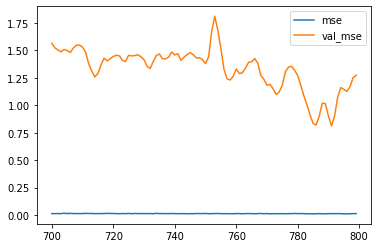

Prediction = 0.0506906695663929
Last corr = 0.974008
wal_mtb corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.0506906695663929 
----------
Stock pairing = wal_jpm
Pct finished = 0.006666666666666667
n_sequences 848
Training idx start at 0
Pct finished = 0.1179245283018868
Pct finished = 0.2358490566037736
Pct finished = 0.35377358490566035
Pct finished = 0.4716981132075472
Pct finished = 0.589622641509434
Pct finished = 0.7075471698113207
Pct finished = 0.8254716981132075
Pct finished = 0.9433962264150944
Training idx end at 824
Total idx checked 849
Val idx start at 825
Val idx end at 849
X val shape (10, 14, 4956)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x143795128> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x15c3ea7b8> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x15756e358> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1567bc470> Fa

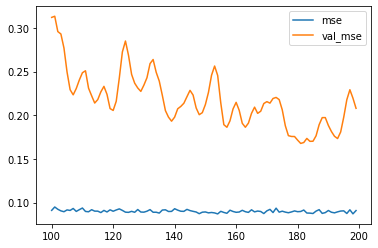

Prediction = 1.5245156288146973
Last corr = 0.956929
wal_jpm corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 1.5245156288146973 
----------
Stock pairing = wal_umpq
Pct finished = 0.013333333333333334
n_sequences 848
Training idx start at 0
Pct finished = 0.1179245283018868
Pct finished = 0.2358490566037736
Pct finished = 0.35377358490566035
Pct finished = 0.4716981132075472
Pct finished = 0.589622641509434
Pct finished = 0.7075471698113207
Pct finished = 0.8254716981132075
Pct finished = 0.9433962264150944
Training idx end at 824
Total idx checked 849
Val idx start at 825
Val idx end at 849
X val shape (10, 14, 4956)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x143795128> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x15c3ea7b8> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x15756e358> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1567bc470> F

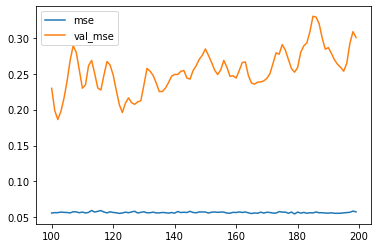

Prediction = 1.3534592390060425
Last corr = 0.989008
wal_umpq corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 1.3534592390060425 
----------
Stock pairing = wal_cvbf
Pct finished = 0.02
n_sequences 848
Training idx start at 0
Pct finished = 0.1179245283018868
Pct finished = 0.2358490566037736
Pct finished = 0.35377358490566035
Pct finished = 0.4716981132075472
Pct finished = 0.589622641509434
Pct finished = 0.7075471698113207
Pct finished = 0.8254716981132075
Pct finished = 0.9433962264150944
Training idx end at 824
Total idx checked 849
Val idx start at 825
Val idx end at 849
X val shape (10, 14, 4956)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x143795128> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x15c3ea7b8> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x15756e358> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1567bc470> False
<tensorflo

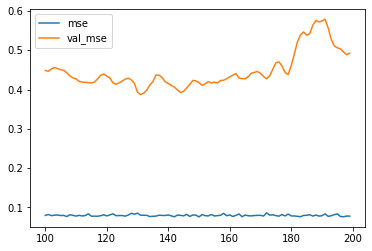

Prediction = 2.580435037612915
Last corr = 0.986554
wal_cvbf corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 2.580435037612915 
----------
Stock pairing = wal_fitb
Pct finished = 0.02666666666666667
n_sequences 848
Training idx start at 0
Pct finished = 0.1179245283018868
Pct finished = 0.2358490566037736
Pct finished = 0.35377358490566035
Pct finished = 0.4716981132075472
Pct finished = 0.589622641509434
Pct finished = 0.7075471698113207
Pct finished = 0.8254716981132075
Pct finished = 0.9433962264150944
Training idx end at 824
Total idx checked 849
Val idx start at 825
Val idx end at 849
X val shape (10, 14, 4956)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x143795128> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x15c3ea7b8> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x15756e358> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1567bc470> Fal

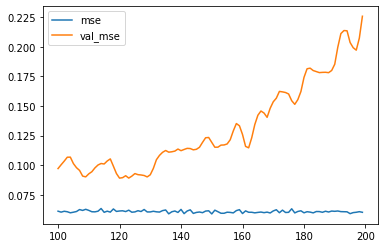

Prediction = 1.2648135423660278
Last corr = 0.979363
wal_fitb corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 1.2648135423660278 
----------
Stock pairing = wal_irm
Pct finished = 0.03333333333333333
n_sequences 848
Training idx start at 0
Pct finished = 0.1179245283018868
Pct finished = 0.2358490566037736
Pct finished = 0.35377358490566035
Pct finished = 0.4716981132075472
Pct finished = 0.589622641509434
Pct finished = 0.7075471698113207
Pct finished = 0.8254716981132075
Pct finished = 0.9433962264150944
Training idx end at 824
Total idx checked 849
Val idx start at 825
Val idx end at 849
X val shape (10, 14, 4956)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x143795128> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x15c3ea7b8> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x15756e358> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1567bc470> Fa

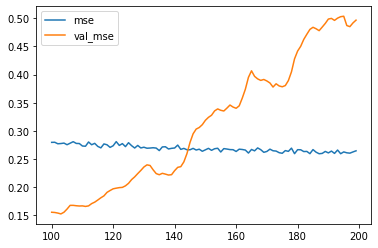

Prediction = 0.9367712736129761
Last corr = 0.954229
wal_irm corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.9367712736129761 
----------
Stock pairing = wal_wfc
Pct finished = 0.04
n_sequences 848
Training idx start at 0
Pct finished = 0.1179245283018868
Pct finished = 0.2358490566037736
Pct finished = 0.35377358490566035
Pct finished = 0.4716981132075472
Pct finished = 0.589622641509434
Pct finished = 0.7075471698113207
Pct finished = 0.8254716981132075
Pct finished = 0.9433962264150944
Training idx end at 824
Total idx checked 849
Val idx start at 825
Val idx end at 849
X val shape (10, 14, 4956)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x143795128> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x15c3ea7b8> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x15756e358> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1567bc470> False
<tensorflow.

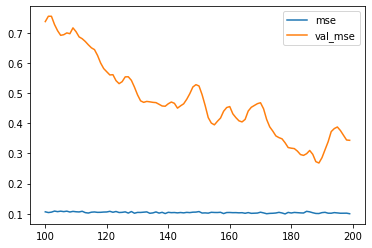

Prediction = 0.7381609678268433
Last corr = 0.916556
wal_wfc corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is 0.7381609678268433 
----------
Stock pairing = wal_cwbc
Pct finished = 0.04666666666666667
n_sequences 848
Training idx start at 0
Pct finished = 0.1179245283018868
Pct finished = 0.2358490566037736
Pct finished = 0.35377358490566035
Pct finished = 0.4716981132075472
Pct finished = 0.589622641509434
Pct finished = 0.7075471698113207
Pct finished = 0.8254716981132075
Pct finished = 0.9433962264150944
Training idx end at 824
Total idx checked 849
Val idx start at 825
Val idx end at 849
X val shape (10, 14, 4956)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x143795128> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x15c3ea7b8> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x15756e358> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1567bc470> Fa

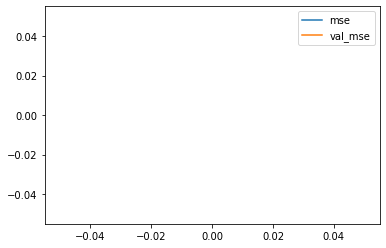

Prediction = nan
Last corr = 0.772589
wal_cwbc corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is nan 
----------
Stock pairing = wal_bsrr
Pct finished = 0.05333333333333334
n_sequences 848
Training idx start at 0
Pct finished = 0.1179245283018868
Pct finished = 0.2358490566037736
Pct finished = 0.35377358490566035
Pct finished = 0.4716981132075472
Pct finished = 0.589622641509434
Pct finished = 0.7075471698113207
Pct finished = 0.8254716981132075
Pct finished = 0.9433962264150944
Training idx end at 824
Total idx checked 849
Val idx start at 825
Val idx end at 849
X val shape (10, 14, 4956)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x143795128> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x15c3ea7b8> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x15756e358> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1567bc470> False
<tensorflow.python.keras.

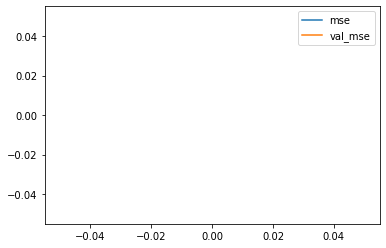

Prediction = nan
Last corr = 0.987764
wal_bsrr corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is nan 
----------
Stock pairing = wal_key
Pct finished = 0.06
n_sequences 848
Training idx start at 0
Pct finished = 0.1179245283018868
Pct finished = 0.2358490566037736
Pct finished = 0.35377358490566035
Pct finished = 0.4716981132075472
Pct finished = 0.589622641509434
Pct finished = 0.7075471698113207
Pct finished = 0.8254716981132075
Pct finished = 0.9433962264150944
Training idx end at 824
Total idx checked 849
Val idx start at 825
Val idx end at 849
X val shape (10, 14, 4956)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x143795128> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x15c3ea7b8> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x15756e358> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1567bc470> False
<tensorflow.python.keras.layers.recurrent

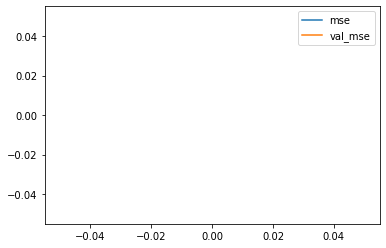

Prediction = nan
Last corr = 0.990574
wal_key corr7-day corr of close from 2020-05-15 00:00:00 to 2020-05-22 00:00:00 is nan 
----------
Stock pairing = wal_ewbc
Pct finished = 0.06666666666666667
n_sequences 848
Training idx start at 0
Pct finished = 0.1179245283018868
Pct finished = 0.2358490566037736
Pct finished = 0.35377358490566035
Pct finished = 0.4716981132075472
Pct finished = 0.589622641509434
Pct finished = 0.7075471698113207
Pct finished = 0.8254716981132075
Pct finished = 0.9433962264150944
Training idx end at 824
Total idx checked 849
Val idx start at 825
Val idx end at 849
X val shape (10, 14, 4956)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x143795128> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x15c3ea7b8> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x15756e358> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1567bc470> False
<tensorflow.python.keras.l

KeyboardInterrupt: 

In [707]:
# 6.5 minutes for 10 stocks
final_stock_df = final_stock_df.dropna()
# test 14 day period instead of 30
# no dice
# test smaller network smae LR
# no dice
# test since 2016 data
# no dice
# test smaller learning rate 
# no dice
# test smaller batch size
# nothing
# test batch size  one

# so the solution was less validation data

# wal_cwbc is nan
prediction_for_upcoming_week(final_stock_df, pairs_of_stocks[:150])

In [ ]:
np.isnan(X).sum()

In [ ]:
np.isnan(y).sum()

In [ ]:
np.isnan(X_val).sum()

In [381]:
np.isnan(test_X).sum()

0

In [741]:
X.shape

(920, 30, 7609)

In [764]:
X

array([[[ 6.3315147e-01, -4.0225439e-02, -2.0955741e-01, ...,
         -1.3089590e+00, -1.3580441e+00, -8.1021920e-02],
        [ 4.9237117e-01, -2.9718536e-01, -8.0603009e-01, ...,
         -1.3116791e+00, -1.3609316e+00, -8.7561585e-02],
        [ 6.7750984e-01,  6.4380622e-01, -4.8963074e-02, ...,
         -1.3144102e+00, -1.3638312e+00, -8.7561585e-02],
        ...,
        [-3.3272165e-01, -6.7840558e-01, -3.8611093e-01, ...,
         -1.3863686e+00, -1.4404267e+00, -9.3658574e-02],
        [ 1.1757526e-02, -4.0714911e-01, -1.0684547e+00, ...,
         -1.3894027e+00, -1.4436650e+00, -9.3658574e-02],
        [ 7.2871464e-01, -5.0212055e-01, -8.4904128e-01, ...,
         -1.3924494e+00, -1.4469175e+00, -9.3658574e-02]],

       [[ 4.9250159e-01, -2.9696226e-01, -8.0589026e-01, ...,
         -1.3089590e+00, -1.3580441e+00, -8.1021920e-02],
        [ 6.7783940e-01,  6.4417285e-01, -4.9141262e-02, ...,
         -1.3116791e+00, -1.3609316e+00, -8.7561585e-02],
        [ 3.5224825e-01, 

In [765]:
start = time.time()
pca_scalers = {}
new_X = []
for i in range(X.shape[1]):
    pca_scalers[i] = PCA(.80)
    new_X.append(pca_scalers[i].fit_transform(X[:, i, :]) 
end = time.time()

print((end-start)/60)

ValueError: could not broadcast input array from shape (920,51) into shape (920,7609)